# <u>Multi-Layer Perceptron</u>

Le "Mutli-Layer Perceptron" (MLP) signifie, perceptron multi-couches. C'est une méthode qui permet de créer un réseau de neurones qui prend en entrée des données
à partir d'une couche d'entrée et qui nous donne à partir d'une couche de sortie autant de variables que l'on cherche
à prédire.

Entre ces deux couches, on a entre ces deux couches, des couches cachées qui chacun dispose d'un nombre de neurones:

<img src="https://imgur.com/HV1FPja.png">

<small><small>Source : https://www.tutorialspoint.com/tensorflow/tensorflow_multi_layer_perceptron_learning.htm</small></small>

Une méthode pour créer une réseau de neurones, serait donc d'utiliser la classe `Sequential()` et la classe `Dense()` pour créer 
un modèle utilisant ces différentes couches cachées de la manière suivante:


Nous allons voir si effectivement, le perceptron multi-couches est une méthode viable pour prédire nos différentes classes
présentes dans le dataset CIFAR-10.

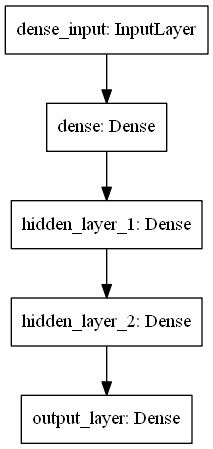

In [3]:
# Import des librairies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import plot_model

# Création des couches du réseau
n_neurons = 32 
n_classes = 10 # dogs, boats, planes...
input_dim = 32 * 32 * 3 # 32px * 32px * 3 (RGB)

input_layer = Dense(n_neurons, input_dim=input_dim)
hidden_layer_1 = Dense(n_neurons, name="hidden_layer_1")
hidden_layer_2 = Dense(n_neurons, name="hidden_layer_2")
output_layer = Dense(n_classes, activation=softmax, name="output_layer")

# Enregistrement du modèle
model = Sequential()
model.add(input_layer)
model.add(hidden_layer_1)
model.add(hidden_layer_2)
model.add(output_layer)

# Affichage de l'image
plot_model(model)

Avec ce principe, on observe que l'on obtient un schéma de modèle similaire à celui plus haut.
Peut-on obtenir un résultat intéressant avec ce modèle ?

In [4]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from src.helper import Helper

model.compile(
    loss=sparse_categorical_crossentropy,
    metrics=[sparse_categorical_accuracy]
)

helper = Helper()
(x_train, y_train), (x_test, y_test) = helper.get_cifar10_prepared()

helper.fit(
    model, x_train, y_train, 1024, 100, (x_test, y_test), "mlp"
)

Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\responses\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\responses\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\checkpoints\
Couldn't create the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\tensorboard\fit\
Couldn't create the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\tensorboard\fit\mlp_1_20200130-100206\
C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\mlp_1.log
C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\checkpoints\mlp_1.ckpt
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
46080/50000 [==========================>.

... la réponse est non, un accuracy aussi pas ne nous satisfait pas, néanmoins le réseau de neurones reste
toujours plus intéressant qu'un modèle linéaire qui ne nous prédit pas grand chose.

En effet, juste en faisant un simple tirage aléatoire on aurait une précision de 10% approximativement pour chaque tirage.
Or ce modèle peut obtenir 40%, ce qui est simplement 4 fois plus efficace que de faire confiance à la chance.

Mais ne peut-on pas obtenir un résultat encore meilleur en optimisant les paramètres que nous avons donnés ?

Nous avons constaté une croissance au fil du dernier entrainement de notre modèle. Est-il possible de conclure sur le fait
que plus d'itérations nous aurait permis une meilleure précision globale ?

In [5]:
helper.fit(
    model, x_train, y_train, 1024, 1000, (x_test, y_test), "mlp"
)

Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\responses\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\responses\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\checkpoints\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\tensorboard\fit\
Successfully created the dir : C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\tensorboard\fit\mlp_2_20200130-101321\
C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\logs\mlp_2.log
C:\Users\thuchard\PycharmProjects\dl-kaggle-dataset-analysis\src\models\checkpoints\mlp_2.ckpt
Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
48128/50000 [=================

On obtient effectivement une meilleure précision globale, cependant, cela prend significativement plus de temps pour obtenir une
précision correcte.

De plus on observe un écart entre notre précision d'entrainement et notre précision de validation. Le fait de 
juste augmenter notre nombre d'epochs ne suffit pas.

D'autres hyperparamètres pourraient être plus efficace pour la recherche de notre meilleur modèle type "perceptron multi-couches". 

Cependant, tester nos valeurs à la main pourraient prendre beaucoup de temps. Nous allons donc générer un outil
qui va nous permettre de "tuner" nos hyperparamètres pour ne pas que nous ayons à le faire manuellement.

Nous allons donc suivre le principe suivant :

1) La création d'un objet "Tuner" va prendre en compte des listes d'hyperparamètres.

2) Le tuner va permettre de créer des "scénarios" qui permettent la génération de suite d'entrainements.

3) Le tuner va pouvoir lancer un scénario qui durera pour une durée indéfinie.

4) Une fois le scénario terminé, nous pourrons comparer nos modèles grâce à tensorboard et déterminer vers quelle direction
continuer en triant les modèles par un score définit par les paramètres suivants :

* Le niveau d'overfitting
* Le niveau d'underfitting
* L'accuracy du modèle

Nous aurons alors simplement à garder les modèles qui auront le score le plus élevé.

Soit $x$ notre précision d'entraînement et $y$ notre précision de validation.

On pose alors :

<div style="width:100%; text-align:center;">
$
\phi = min(x,y)$ ; $\gamma = max(x,y)
$
</div>
<br>
Alors le score est définit par la formule suivante :
<br><br>
<div style="width:100%; text-align:center;">
$
Score =  10\ \phi\ (1 + \dfrac{\phi}{\gamma})
$
</div>
<br>

Cette formule va alors nous donner un score compris entre 0 et 20 qui est basé sur l'underfitting, l'overfitting et la précision globale de notre modèle.

En évaluant nos deux derniers datasets, voici ce que l'on obtient comme score (avec mlp_1 = le modèle à 100 epochs et mlp_2 = le modèle à 200 epochs):

In [1]:
from src.helper import Helper

helper = Helper()
models_scores = helper.evaluate_models(2)
print(models_scores)

{'mlp_1': 7.848930773986473, 'mlp_2': 7.461989741107279}


En utilisant un script de génération de modèles on peut donc tuner nos hyperparamètres, et ensuite évaluer les modèles entrainés grâce à notre fonction `evaluate_models(n)`.

Dans un premier temps nous allons générer donc générer un scénario :

In [2]:
from src.tuner import Tuner

# Create tuner
mlp_tuner = Tuner(
    "mlp",
    dropouts=["NoDropout", "DropoutDescending", "DropoutConstant"],
    dropout_values=[0.2, 0.1],
    optimizers=["SGD", "Adam", "Adamax"],
    activation_functions=["tanh", "relu", "sigmoid", "softmax"],
    batch_sizes=[32, 64, 128, 256]
)

# Load dataset
(x_train, y_train), (x_test, y_test) = src.helper.get_cifar10_prepared()

mlp_tuner.create_scenario("scenario_1")
src.helper.inspect_scenario("scenario_1")

Successfully created the dir : ./scenarios
Successfully created the dir : ./scenarios/mlp
Successfully created the "./scenarios/mlp/scenario_1.csv" file.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________
Successfully created the dir : c:\users\thuchard\pycharmprojects\dl-kaggle-dataset-analysis\src\models\responses\
Successfully created the dir : c:\users\thuchard\pycharmprojects\dl-kaggle-dataset-analysis\src\models\responses

Epoch 1/2
48896/50000 [============================>.] - ETA: 0s - loss: 2.0834 - sparse_categorical_accuracy: 0.2504
Epoch 00001: saving model to c:\users\thuchard\pycharmprojects\dl-kaggle-dataset-analysis\src\models\checkpoints\mlp_6.ckpt
50000/50000 [==============================] - 3s 65us/sample - loss: 2.0806 - sparse_categorical_accuracy: 0.2520 - val_loss: 2.0066 - val_sparse_categorical_accuracy: 0.2663
Epoch 2/2
49408/50000 [============================>.] - ETA: 0s - loss: 1.9020 - sparse_categorical_accuracy: 0.3333
Epoch 00002: saving model to c:\users\thuchard\pycharmprojects\dl-kaggle-dataset-analysis\src\models\checkpoints\mlp_6.ckpt
50000/50000 [==============================] - 2s 41us/sample - loss: 1.9014 - sparse_categorical_accuracy: 0.3334 - val_loss: 1.8661 - val_sparse_categorical_accuracy: 0.3466
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (

KeyboardInterrupt: 